# Integrated project 2

## About project


Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

## Project plan

**1. Prepare the data**

    1.1. Open the files and look into the data.
        
    1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the    rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
    
    1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
    
    1.4. Perform data preprocessing.
    
**2. Analyze the data**

    2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
    
    2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
    
    2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
    
**3. Build the model**

    3.1. Write a function to calculate the final sMAPE value.
    
    3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

### 1. Prepare the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

print('----------Train data set----------')
train.head()


----------Train data set----------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [3]:
print('----------Test data set----------')
test.head()

----------Test data set----------


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [4]:
print('----------Full data set----------')
full_data.head()

----------Full data set----------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
print('----------Train data set----------')
print(train.info())

----------Train data set----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cl

In [6]:
print('----------Test data set----------')
print(test.info())

----------Test data set----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level    

In [7]:
print('----------Full data set----------')
print(full_data.info())

----------Full data set----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cle

Here we have opened data looked into data. And we get general info about datatsets using `info()` method. 

In [8]:
def recovery_calculate(df):
    c = df['rougher.output.concentrate_au'] 
    f = df['rougher.input.feed_au'] 
    t = df['rougher.output.tail_au'] 
  
    
    upper = c * (f - t)
    lower = f * (c - t)
    recovery = upper / lower * 100
                    
    return recovery

In [9]:
train_recovery = train.dropna()

In [10]:
recovery = train_recovery.apply(recovery_calculate, axis = 1)

mae = mean_absolute_error(train_recovery['rougher.output.recovery'],recovery)
print('Mean absolute error according to our calculatins: {}'.format(mae))

Mean absolute error according to our calculatins: 9.555596961987514e-15


On this stage we have calculated recovery according to formula that given us. As wee see we got very very small `MAE` that means our calculations and recovery on dataset calculated correctly.

In [11]:
not_in_test = full_data.columns.difference(test.columns)
full_data[not_in_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_au                                  22635 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
primary_cleaner.output.concentrate_ag                 22618 non-null float64
primary_cleaner.output.concentrate_au                 22618 non-null float64
primary_cleaner.output.concentrate_pb       

As we see `test` and `train` datasets differs from each other. On `test` set there is no data about *final* stage and *output* parameter_type.

In [12]:
print('Duplicated rows in train data set: {}'.format(train.duplicated().sum()))
print('Duplicated rows in test data set: {}'.format(test.duplicated().sum()))
print('Duplicated rows in full data set: {}'.format(full_data.duplicated().sum()))

Duplicated rows in train data set: 0
Duplicated rows in test data set: 0
Duplicated rows in full data set: 0


In [13]:
print("Missing values for train data set: {}".format(train.isna().sum().sum()))
print("Missing values for test data set: {}".format(test.isna().sum().sum()))
print("Missing values for full data set: {}".format(full_data.isna().sum().sum()))

Missing values for train data set: 30320
Missing values for test data set: 2360
Missing values for full data set: 36587


In [14]:
# We will set date index for further usings. For.Ex: extracting data that contains both test and full data sets
def index_date(df):
    df = df.set_index('date')
    return df

In [15]:
train = index_date(train)
test = index_date(test)
full_data = index_date(full_data)

In [16]:
def filling_missing_values(df):
    columns = df.columns
    for column in columns:
        value = df[column].median()
        df[column] = df[column].fillna(value)
    return df   

In [17]:
train = train.ffill()
test = test.ffill()
full_data = full_data.ffill()

In [18]:
print("Missing values for train data set: {}".format(train.isna().sum().sum()))
print("Missing values for test data set: {}".format(test.isna().sum().sum()))
print("Missing values for full data set: {}".format(full_data.isna().sum().sum()))

Missing values for train data set: 0
Missing values for test data set: 0
Missing values for full data set: 0


### Conclusion

To sum up, on this step we firstly have opened data and looked into this datasets. As we see `test` and `train` datasets differs from each other. On `test` set there is no data about *final* stage and *output* parameter_type. Then we have calculated recovery. According to our calculation recovery calculated correctly. Then we have performed data preprocessing. For filling missing values we have used `ffill()` of each column to that exactly column.

### 2.Analyze the data

In [19]:
columns = ['raw stage','rougher stage','After 1st purification','After 2nd purification']
df_au = train[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
df_au.columns = columns
df_ag = train[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
df_ag.columns = columns
df_pb = train[['rougher.input.feed_pb','rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]
df_pb.columns = columns

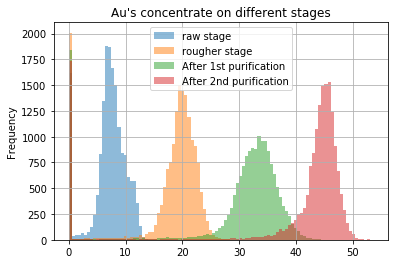

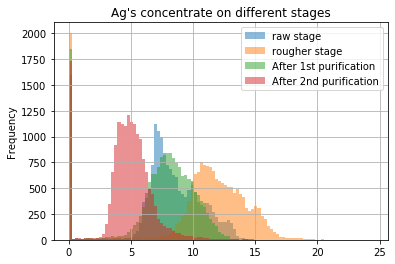

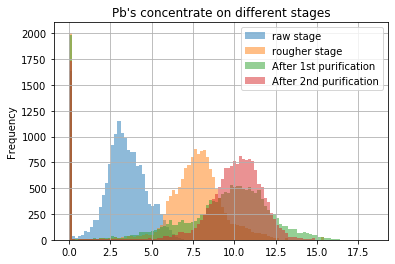

In [20]:
df_au.plot(kind='hist', grid = 'true',alpha=0.5,bins=100)
plt.title("Au's concentrate on different stages")
plt.show()
df_ag.plot(kind='hist', grid = 'true',alpha=0.5,bins=100)
plt.title("Ag's concentrate on different stages")
plt.show()
df_pb.plot(kind='hist', grid = 'true',alpha=0.5,bins=100)
plt.title("Pb's concentrate on different stages")
plt.show()

Here we have collected all data about `concentrates` metals on different stages into one dataframe. Totally we got 3 dataframes, which consists information about *before* and *after* purification stage and *raw* and *final* stage. As wee see after each stage `concentrate_au` increases and other metals concentrate decreases

In [21]:
train_feed_sizes = train['rougher.input.feed_size']
test_feed_sizes = test['rougher.input.feed_size']
data = {"Train" : train_feed_sizes, "Test" : test_feed_sizes}
data_feed_sizes = pd.DataFrame(data)

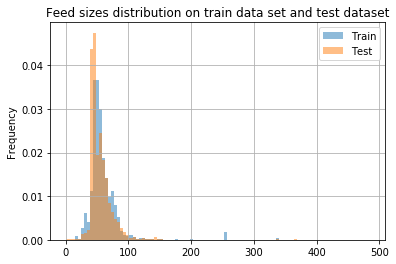

In [22]:
data_feed_sizes.plot(kind='hist', grid=True,bins=100,alpha=0.5,density=True)
plt.title('Feed sizes distribution on train data set and test dataset')
plt.show()


Here we have plotted `feed_sizes` distributions of `train` and `test` data set. According to graphs their distributions not differs much.Also their mean not far to each other. And they distributed on same interval

In [23]:
features_rougher_input_concentrate = ['rougher.input.feed_ag',
                              'rougher.input.feed_pb',                                                                                              
                              'rougher.input.feed_sol',                                
                              'rougher.input.feed_au']
features_rougher_output_concentrate = ['rougher.output.concentrate_ag',
                              'rougher.output.concentrate_pb',                                                                                              
                              'rougher.output.concentrate_sol',                                
                              'rougher.output.concentrate_au']
features_final_output_concentrate = ['final.output.concentrate_ag',
                              'final.output.concentrate_pb',                                                                                              
                              'final.output.concentrate_sol',                                
                              'final.output.concentrate_au']



------------Full data set--------------


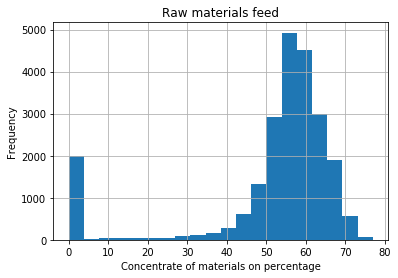

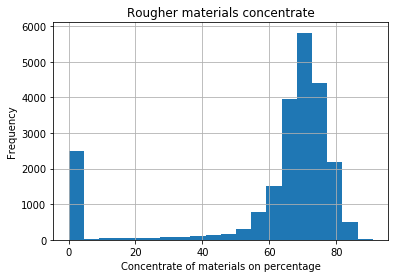

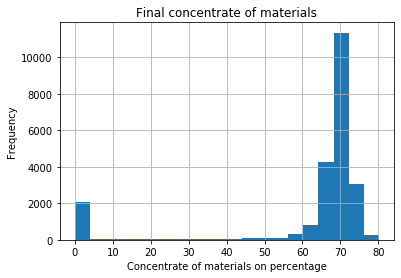

In [24]:
print('------------Full data set--------------')
full_data[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
full_data[features_rougher_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Rougher materials concentrate')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
full_data[features_final_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Final concentrate of materials')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

------------Train data set--------------


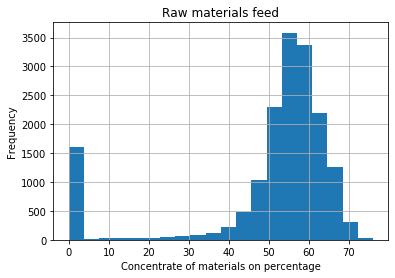

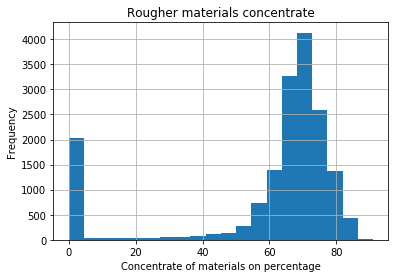

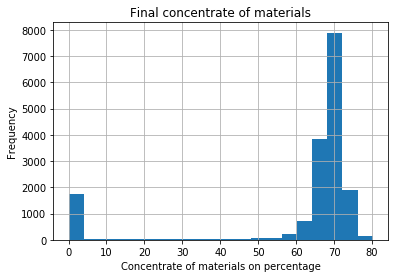

In [25]:
print('------------Train data set--------------')
train[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
train[features_rougher_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Rougher materials concentrate')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
train[features_final_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Final concentrate of materials')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

------------Test data set--------------


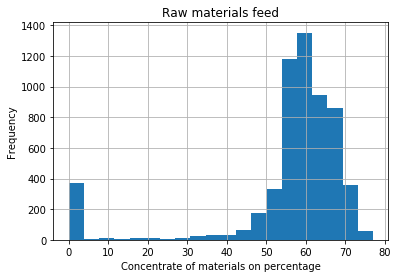

In [26]:
print('------------Test data set--------------')
test[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

In [27]:
def eliminate_outliers(df):
    z_score = np.abs(st.zscore(df))
    df = df[(z_score < 3).all(axis=1)]
    return df

In [28]:
train = eliminate_outliers(train)
test = eliminate_outliers(test)
full_data = eliminate_outliers(full_data)


--------------------After eliminating outliers--------------------
------------Full data set--------------


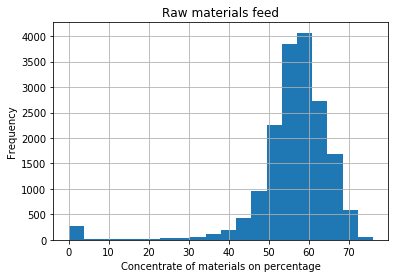

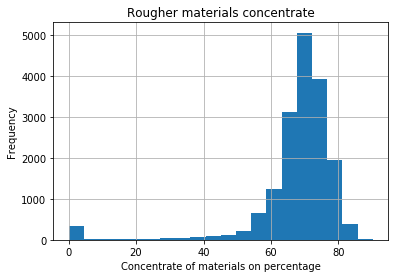

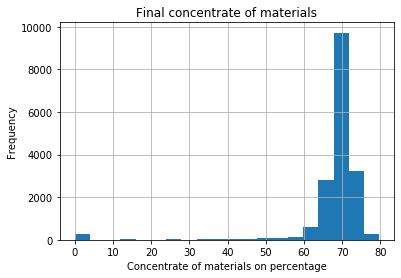

In [29]:
print('--------------------After eliminating outliers--------------------')
print('------------Full data set--------------')
full_data[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
full_data[features_rougher_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Rougher materials concentrate')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
full_data[features_final_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Final concentrate of materials')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

------------Train data set--------------


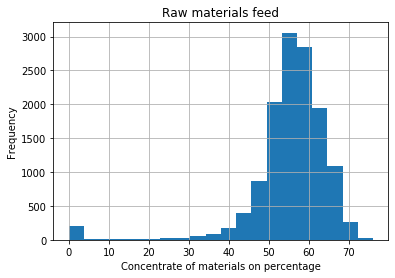

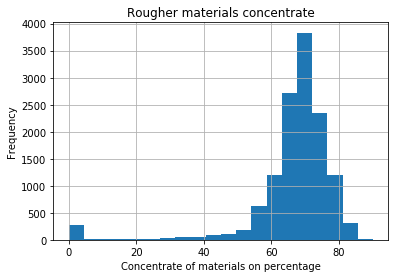

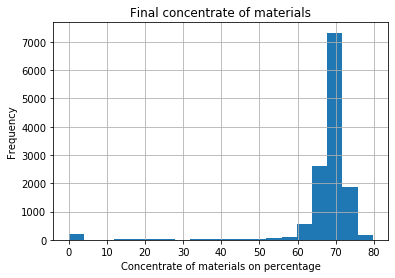

In [30]:
print('------------Train data set--------------')
train[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
train[features_rougher_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Rougher materials concentrate')
plt.xlabel('Concentrate of materials on percentage')
plt.show()
train[features_final_output_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Final concentrate of materials')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

------------Test data set--------------


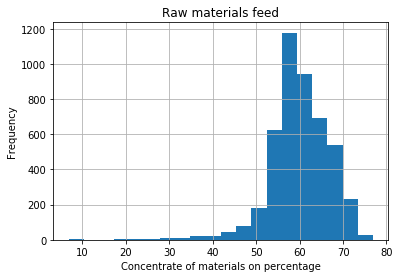

In [31]:
print('------------Test data set--------------')
test[features_rougher_input_concentrate].sum(1).plot(kind='hist',bins=20,grid=True)
plt.title('Raw materials feed')
plt.xlabel('Concentrate of materials on percentage')
plt.show()

### Comment:
I did not understand you quite will. I have eliminated outliers on train and test sets with `eliminate_outliers` function on the above

Here we have considered concentrates of materials on different stages. And we have realized that on all stages there is anomalie around **0**. So we have eliminated this outliers by using `zscore` method. If absolute value of `zscore` less more than 3 we will consider it as an anomalie and outliers. And we checked after eliminating outliers job for done.

### Conclusion

On this step we have analyzed data using graphs. Firstly we have realized that *after* purification `concentrate_au` increases and other metal will decrease. Then we have performed analyze to `feed_sizes` of **train** and **test** datasets. Their distribution not differs much. After that, we analyzed how changes `total concentrates` of data and looked for anomalies and outliers. We have eliminated them. 

### 3. Build the model

In [32]:
def calculate_sMape(target, prediction):
    upper = abs(target - prediction)
    lower = (abs(target) + abs(prediction)) / 2
    values = (upper / lower) * 100
    return values.sum() / len(values)    

Here we have write function, that will calculate `sMape`, according to formula to given us. It will take 2 arguments **target** and **prediction** 

In [33]:
target_train_rougher = train['rougher.output.recovery']
target_train_recovery = train['final.output.recovery']
features_train = train.drop(not_in_test, axis = 1)
features_train.shape
#features_train_rougher = train.drop()
#features_train_final = train.drop(['final.output.recovery'],axis=1)

(13133, 52)

In [34]:
my_score = make_scorer(calculate_sMape, greater_is_better=False)

In [35]:
model = DecisionTreeRegressor(random_state = 12345)
parameters = {
            'max_depth' : range(1,11)
             }
DTR = GridSearchCV(model,param_grid = parameters, scoring=my_score,cv = 5)
DTR.fit(features_train, target_train_rougher)
print(DTR.best_estimator_)
sMape_rougher = DTR.best_score_
model = DecisionTreeRegressor(random_state = 12345)
parameters = {
            'max_depth' : range(1,11)
             }
DTR = GridSearchCV(model,param_grid = parameters, scoring=my_score,cv = 5)
DTR.fit(features_train, target_train_recovery)
print(DTR.best_estimator_)
sMape_final = DTR.best_score_
final_sMape = 0.25 * sMape_rougher + 0.75 * sMape_final
print('Final sMape for DecisionTreeRegressor on test set is {}'.format(final_sMape))

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
Final sMape for DecisionTreeRegressor on test set is -8.150574685792973


In [36]:
model = LinearRegression()
parameters = {
            
             }
LR = GridSearchCV(model,param_grid=parameters, scoring=my_score,cv = 5)
LR.fit(features_train, target_train_rougher)
print(LR.best_estimator_)
sMape_rougher = LR.best_score_
model = LinearRegression()
parameters = {
    
             }
LR = GridSearchCV(model,param_grid = parameters, scoring=my_score,cv = 5)
LR.fit(features_train, target_train_recovery)
print(LR.best_estimator_)
sMape_final = LR.best_score_
final_sMape = 0.25 * sMape_rougher + 0.75 * sMape_final
print('Final sMape for LinearRegression model on train set is {}'.format(final_sMape))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Final sMape for LinearRegression model on train set is -9.071221543936757


In [37]:
model = RandomForestRegressor(random_state = 12345,n_estimators = 100)
parameters = {
            'max_depth' : range(3,6)
             }
RFR = GridSearchCV(model,param_grid = parameters, scoring=my_score,cv = 5)
RFR.fit(features_train, target_train_rougher)
print(RFR.best_estimator_)
sMape_rougher = RFR.best_score_
model = RandomForestRegressor(random_state = 12345,n_estimators = 100)
parameters = {
            'max_depth' : range(3,6)
             }
RFR = GridSearchCV(model,param_grid = parameters, scoring=my_score,cv = 5)
RFR.fit(features_train, target_train_recovery)
print(RFR.best_estimator_)
sMape_final = RFR.best_score_
final_sMape = 0.25 * sMape_rougher + 0.75 * sMape_final
print('Final sMape for RandomForestRegressor model on train set is {}'.format(final_sMape))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)
Final sMape for RandomForestRegressor model on train set is -7.7306224283458

In [38]:
full_data = filling_missing_values(full_data.loc[test.index])
###Targets
full_data_target_recovery = full_data['rougher.output.recovery']
full_data_target_frecovery = full_data['final.output.recovery']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [39]:
target_train_rec = train['rougher.output.recovery']
target_train_frec = train['final.output.recovery']
features_train = train[test.columns]
features_train.shape

(13133, 52)

In [40]:
final_model = RandomForestRegressor(random_state = 12345, max_depth = 5, n_estimators = 100)
final_model.fit(features_train, target_train_rec)
predict_recovery = final_model.predict(test)
rougher_sMape = calculate_sMape(full_data_target_recovery,predict_recovery)
rougher_sMape

4.2043376116656255

In [41]:
final_model1 = RandomForestRegressor(random_state = 12345, max_depth = 4, n_estimators = 100)
final_model1.fit(features_train, target_train_frec)
predict_frec = final_model1.predict(test)
final_sMape = calculate_sMape(full_data_target_frecovery,predict_frec)
final_sMape

7.18876729824059

In [42]:
sMape = 0.25 * rougher_sMape + 0.75 * final_sMape
print("sMape of RandomForest model according to our findings is {:.3f}".format(sMape))

sMape of RandomForest model according to our findings is 6.443


### Conclusion

On this step we have made main part of our ptoject. We used **GridSearchCV** for choosing best model. To calculate our own metrics we made new metrics with `make_scorer`. Also we used 2 different models for two targets. The best model was **RandomForestRegressor**.After that we used test set for predicting values. And we used *loc[]* for getting data that contains both `test` and `full_data` sets. Then we have filled missing values on data with median to avoid *input mismatch problems*. And we have ignored negative values of sMape on test set. Because our scorer optimized to find model wich will find minimum.

## General Conclusion

We have made lots of things to reach here. Firstly opened data and looked into it. then we have performed data preprocessing. After that we have made analyzing. Found outliers and eliminated them. Then we found best model using train set. For this business task **RandomForestRegressor** was best. And we got `sMape` ***6.443***  And we recommend to `Zyfra` to look for other models. Because `time is money` in business. And *RandomForestRegressor* model took about `15 - 20 minutes` in our case. So, it will take lots of time in real world business